<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_positive_rate_etc_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

0      1         2   ...                          10         11      12
0      Date  State  Positive  ...  On Ventilator – Cumulative  Recovered  Deaths
1  20200428     AK       351  ...                                    228       9
2  20200428     AL     6,687  ...                         195                242
3  20200428     AR     3,111  ...                                   1146      52
4  20200428     AS         0  ...                                              0

[5 rows x 13 columns]

In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='coerce')
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['Total'] = full_df.Positive+full_df.Negative.fillna(0)  # New definition
full_df['posrate'] = full_df.Positive / full_df.Total

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MA', 'IL', 'CA', 'PA', 'MI', 'FL', 'LA', 'CT', 'TX',
       'GA', 'MD', 'IN', 'OH', 'CO', 'VA', 'WA', 'TN', 'NC', 'RI', 'MO',
       'AZ', 'AL', 'IA', 'MS', 'WI', 'SC', 'NV', 'DE', 'UT', 'MN', 'KY',
       'DC', 'KS', 'OK', 'NE', 'AR', 'NM', 'OR', 'SD', 'NH', 'ID', 'PR',
       'WV', 'ME'], dtype=object)

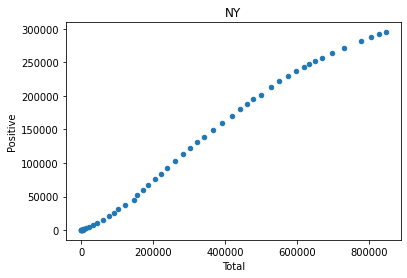

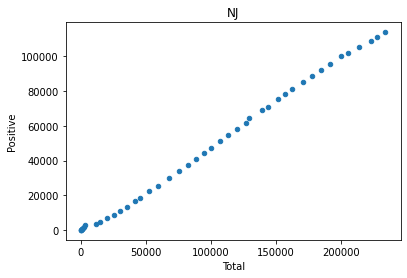

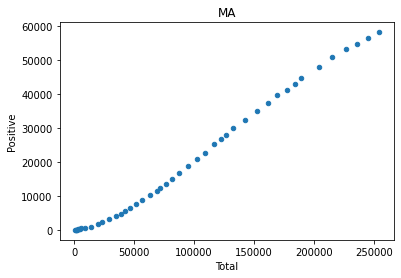

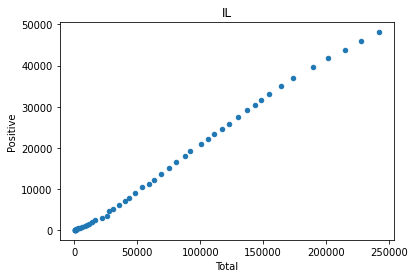

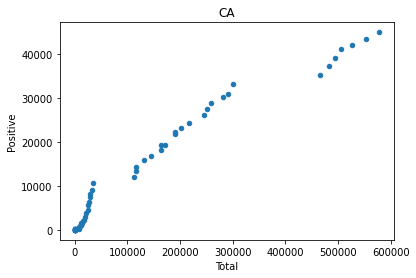

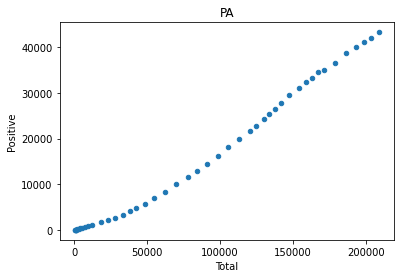

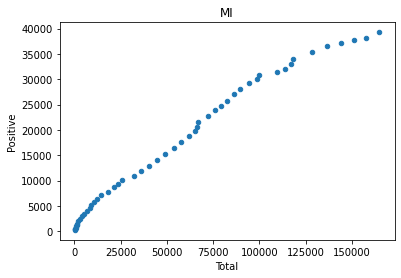

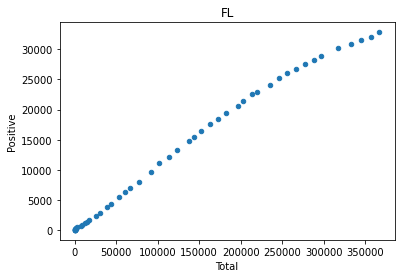

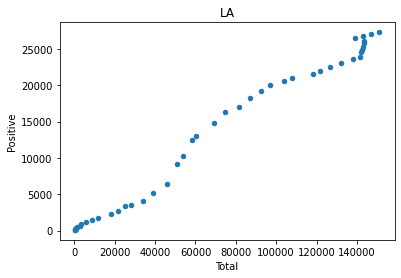

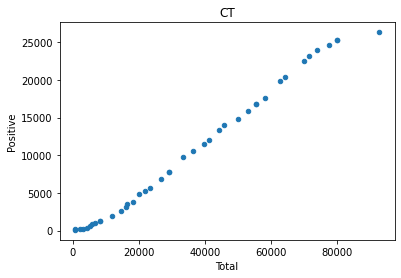

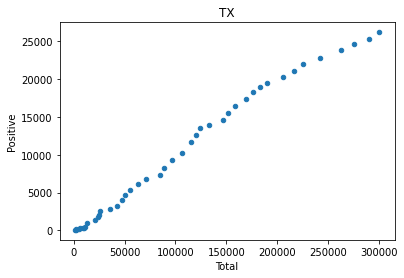

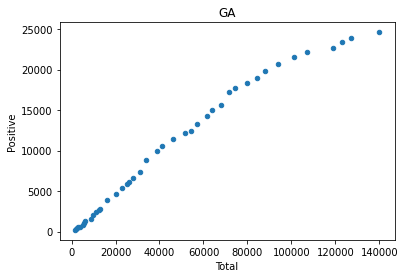

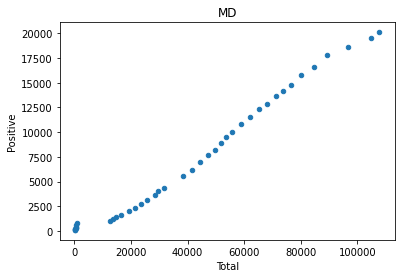

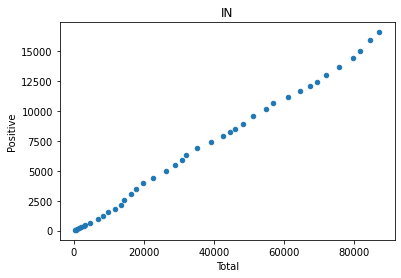

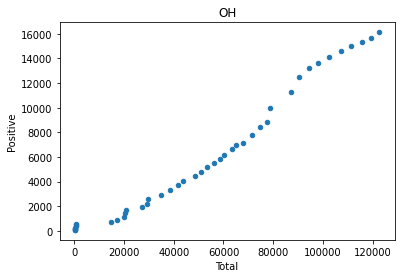

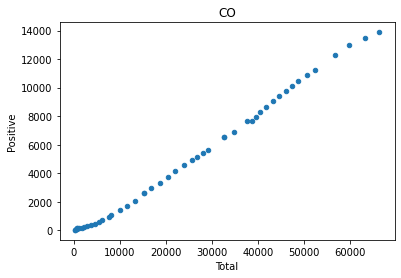

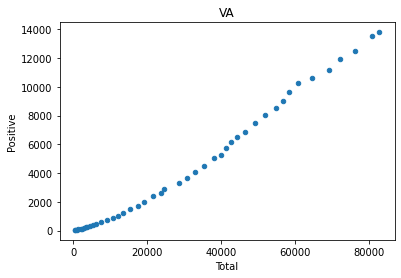

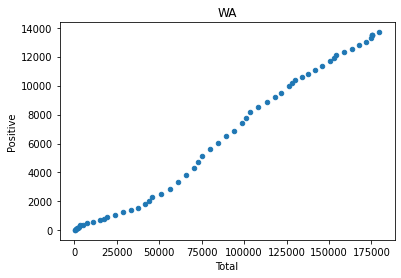

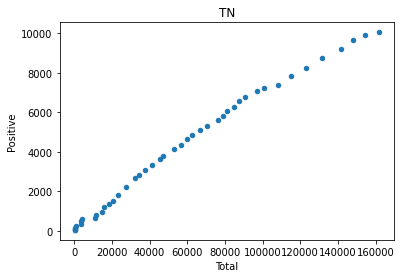

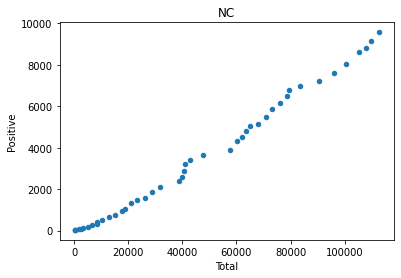

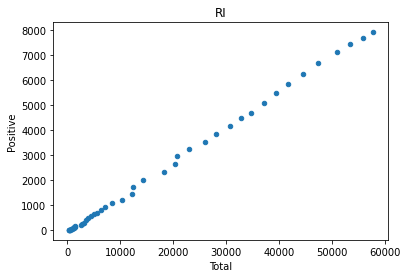

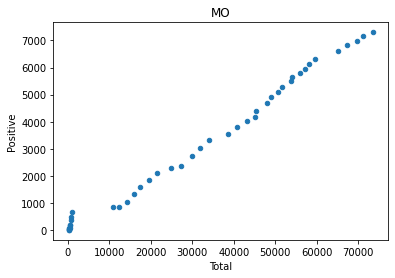

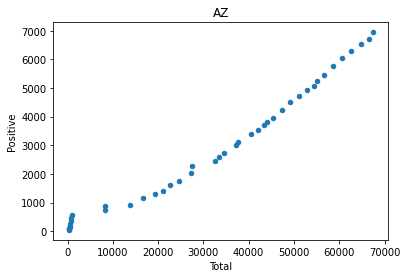

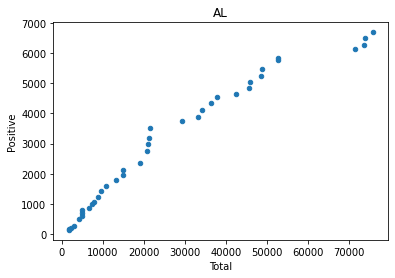

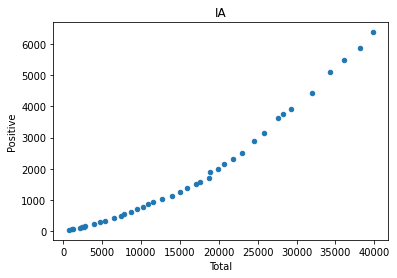

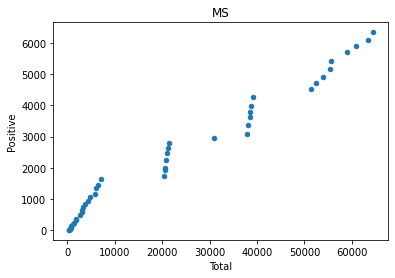

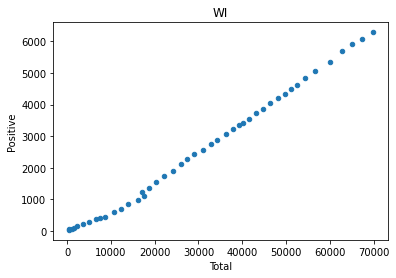

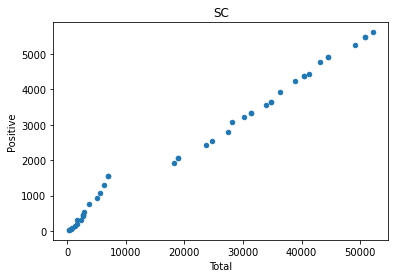

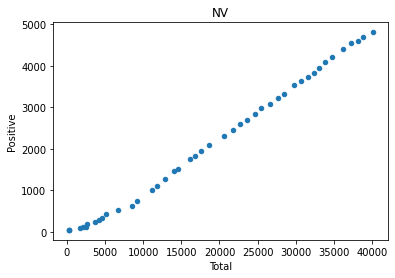

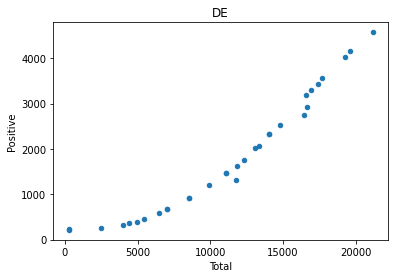

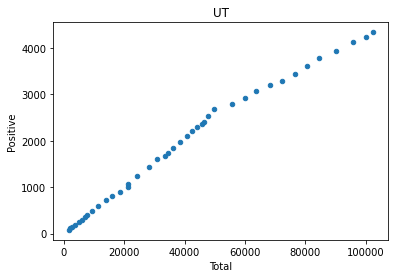

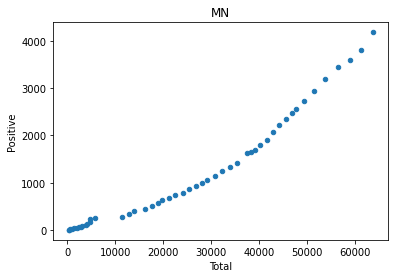

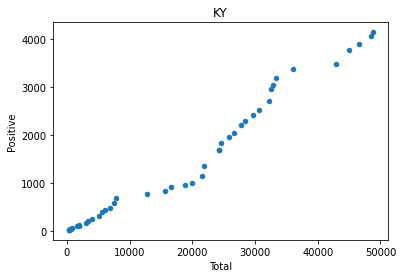

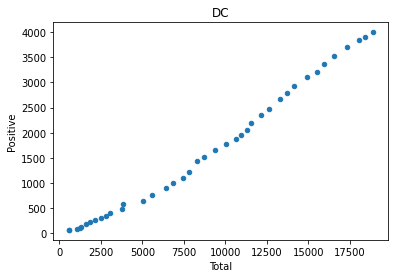

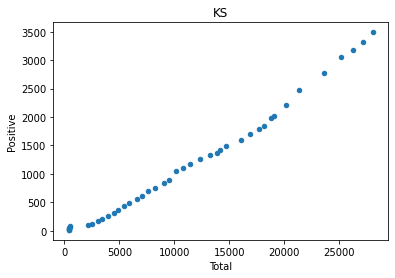

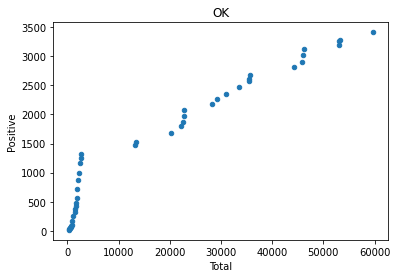

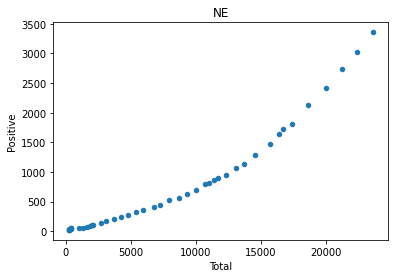

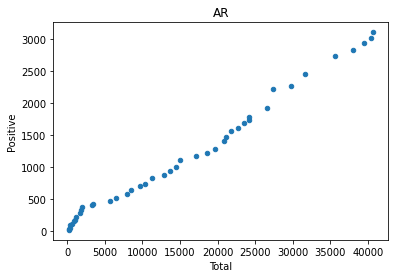

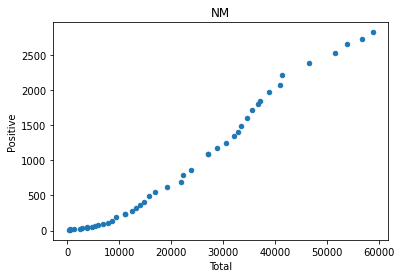

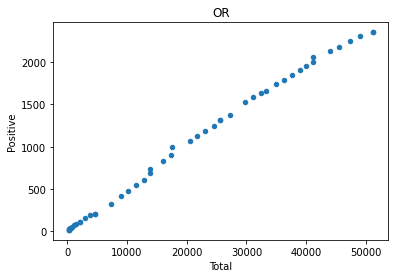

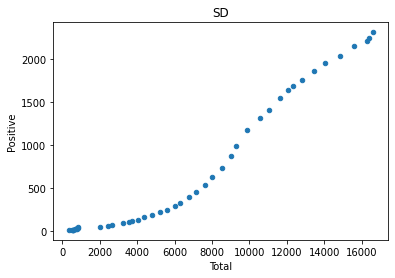

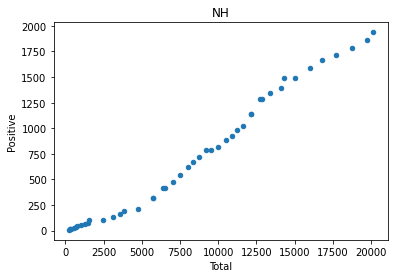

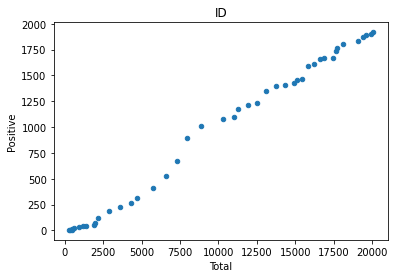

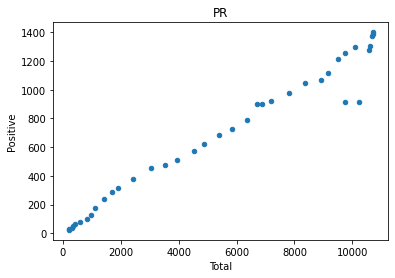

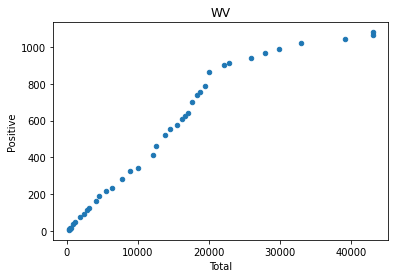

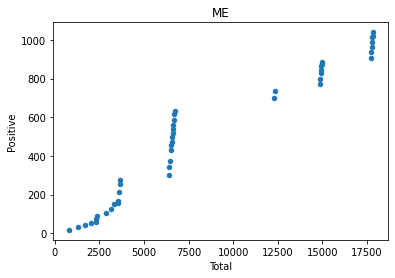

In [11]:
# Scatterplot  "Number of positive tests (confirmed cases)" 
#          vs. "Total number of cumulative tests"  (by state)

# We hope (but thus far do not find) that these plots will eventually start
#   to look like concave functions.  In other words, states should be testing
#   more and more people and hoping that, as testing is broadened, they find
#   a smaller proportion of infections among those tested.

for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

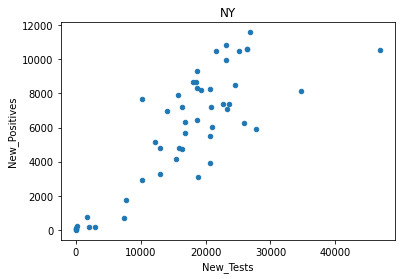

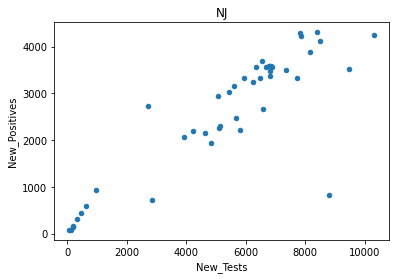

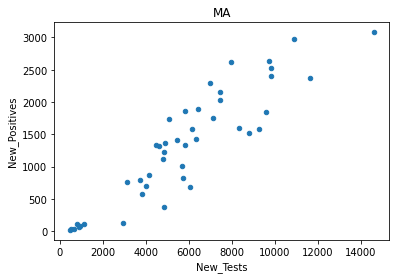

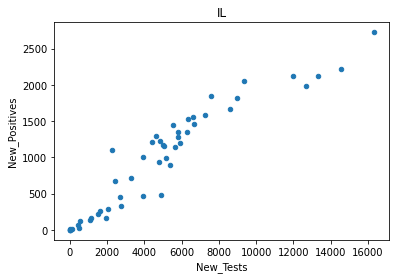

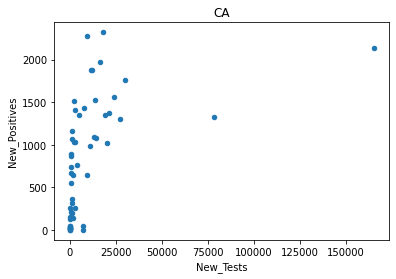

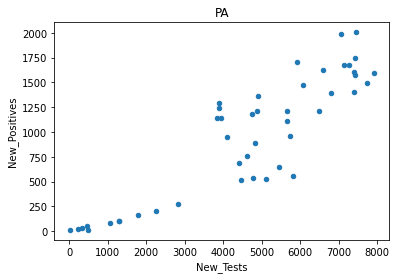

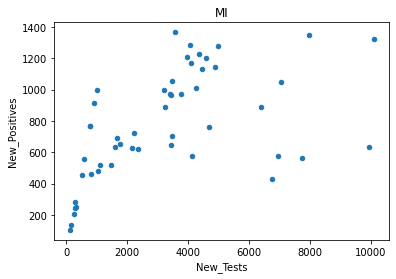

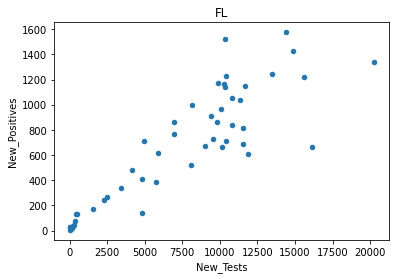

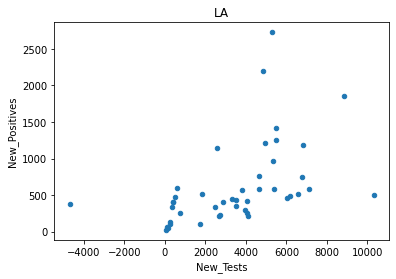

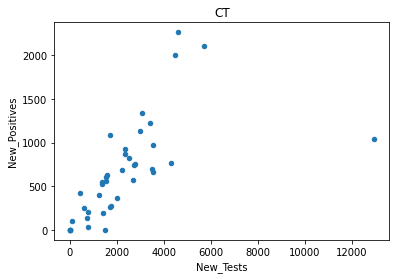

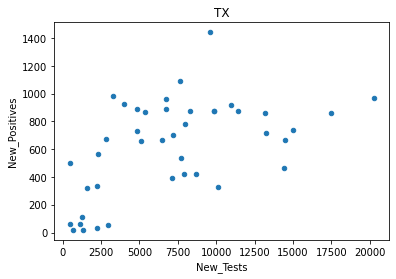

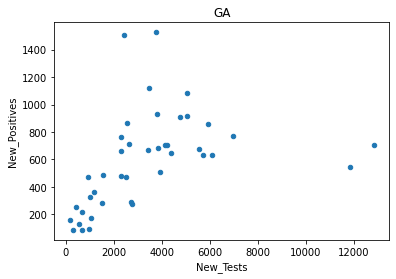

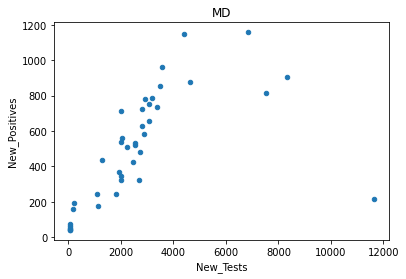

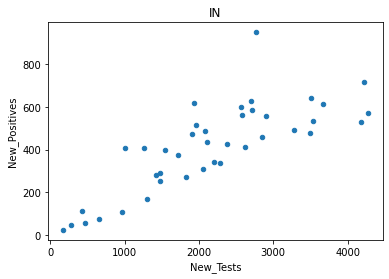

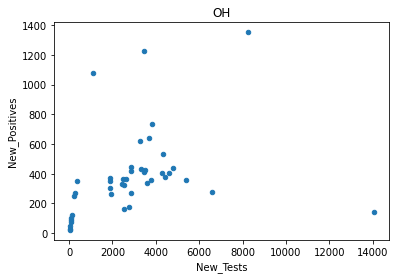

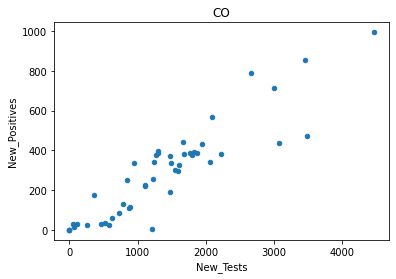

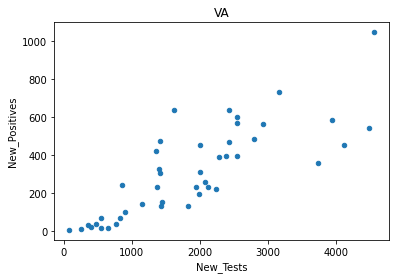

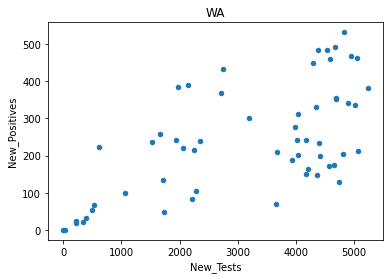

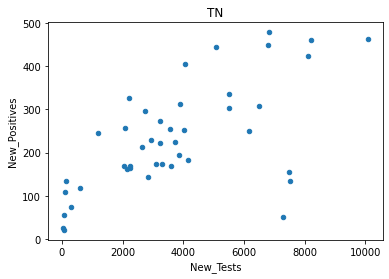

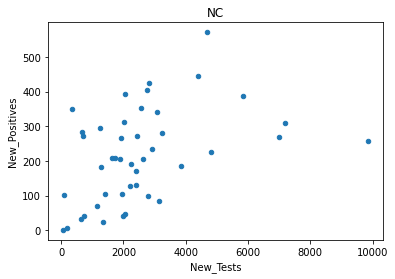

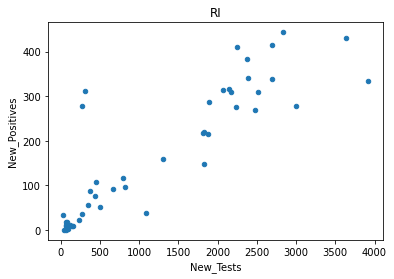

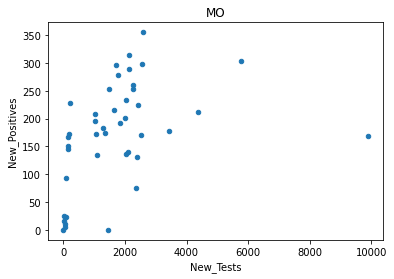

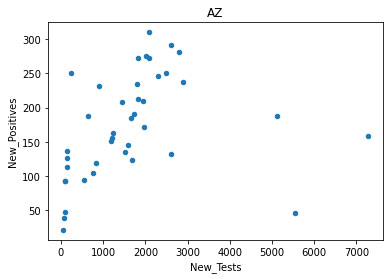

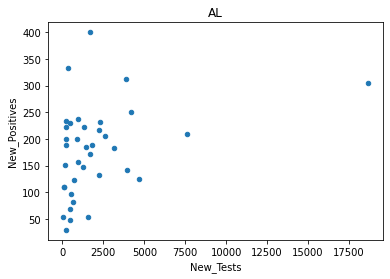

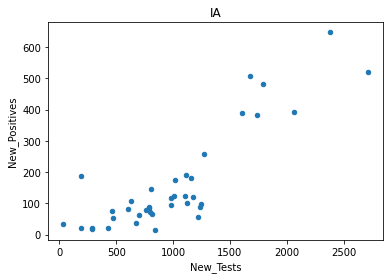

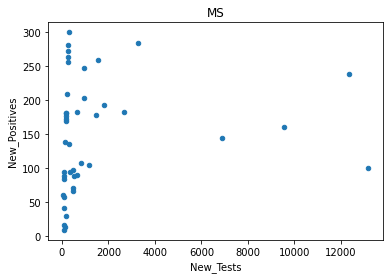

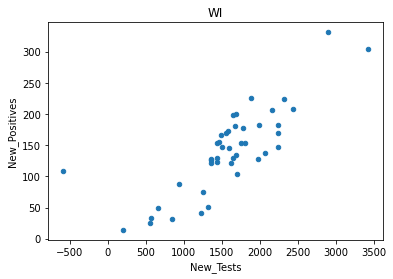

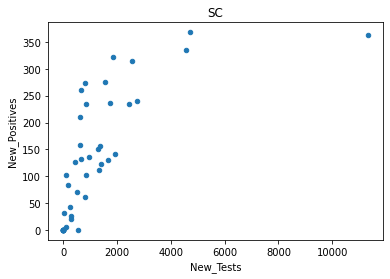

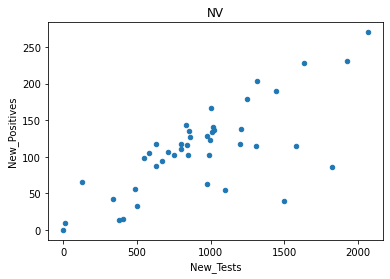

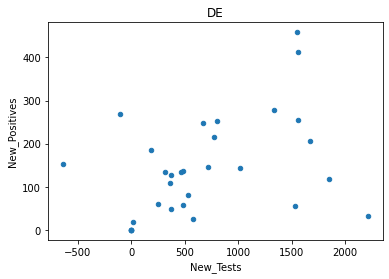

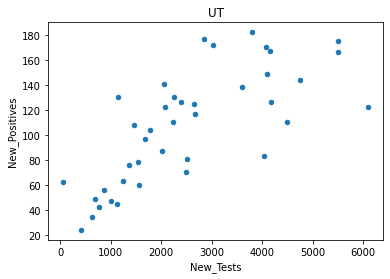

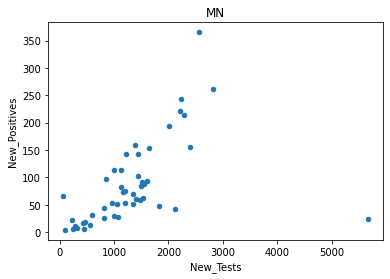

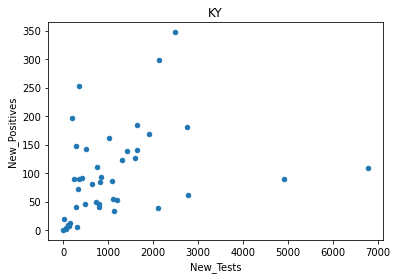

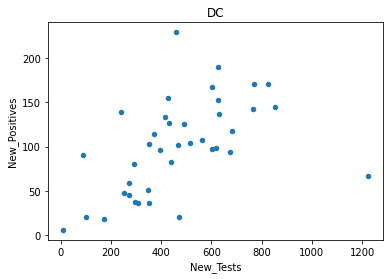

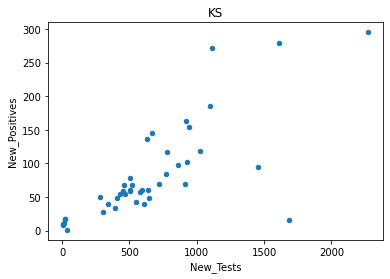

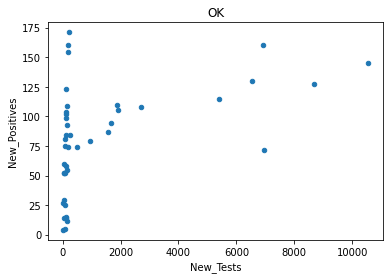

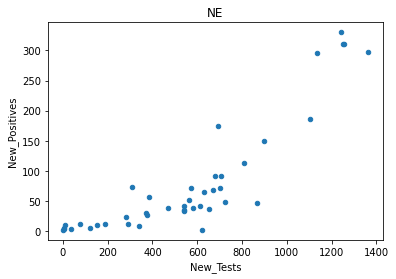

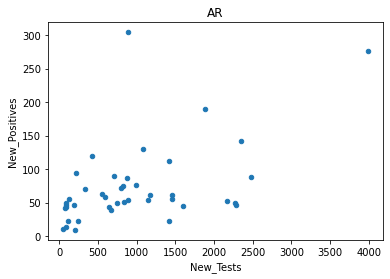

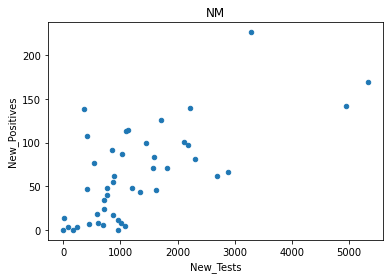

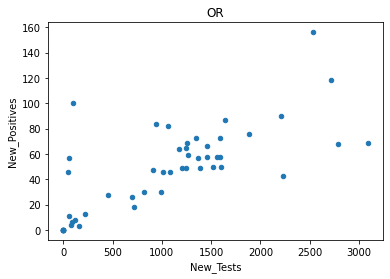

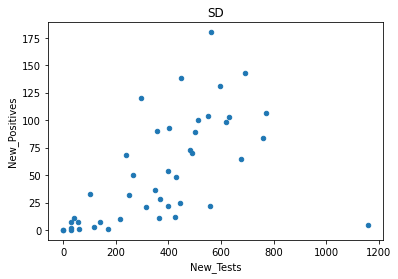

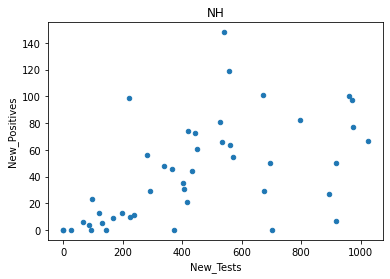

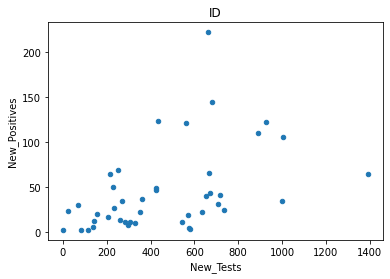

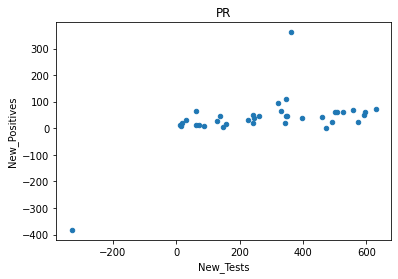

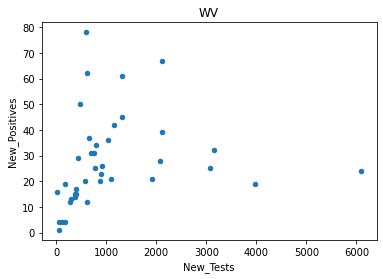

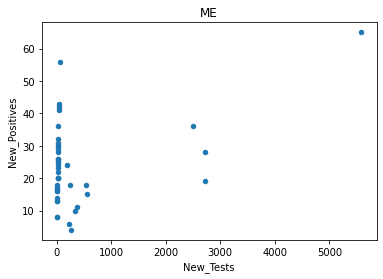

In [12]:
# Scatterplot  "Number of NEW positive tests (latest confirmed cases)" 
#          vs. "Total number of NEW tests"   (by state)

# We hope (but thus far do not find) that these will eventually flatten out.
#   Again, states should be testing more and more people and hoping that, 
#   as testing is broadened, they find a smaller proportion test positive.

for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Tests'] = -df['Total'].diff()
  df['New_Positives'] = -df['Positive'].diff()
  df[df.Total>200][['New_Tests','New_Positives']].plot(kind='scatter', 
                                                       x='New_Tests', 
                                                       y='New_Positives', 
                                                       title=state)
  plt.show()

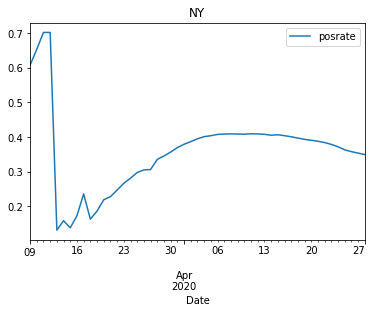

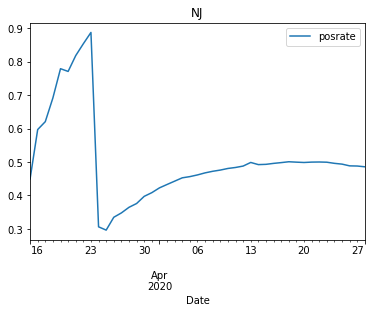

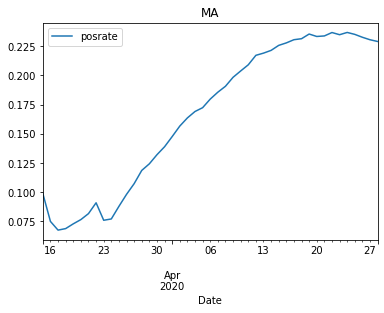

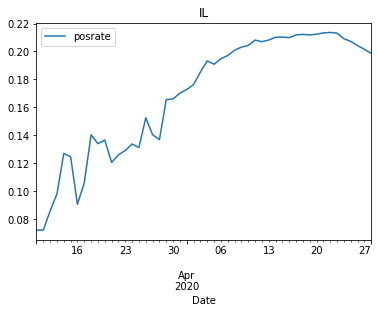

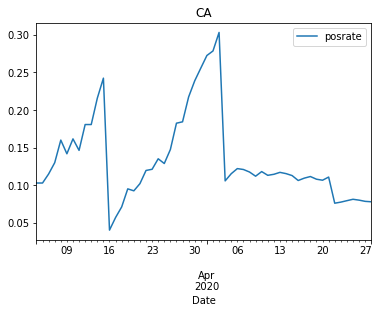

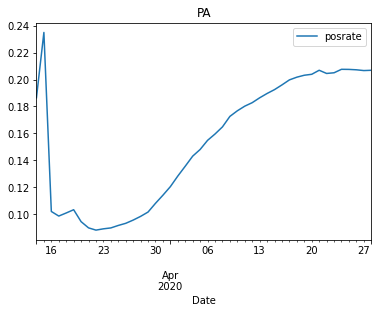

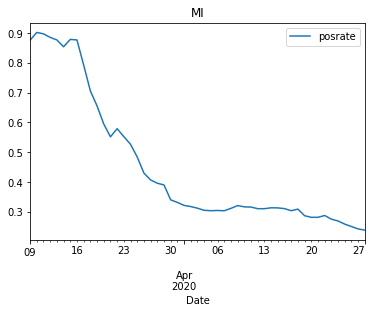

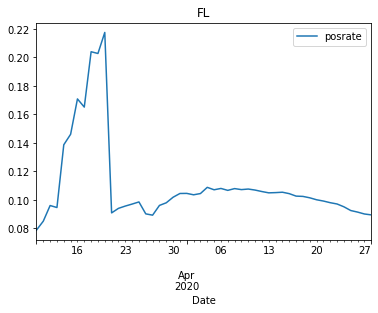

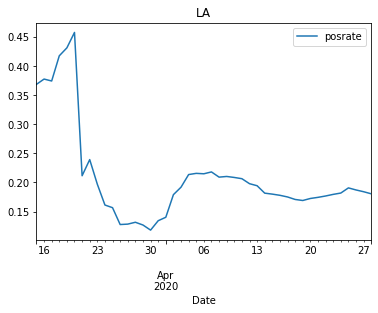

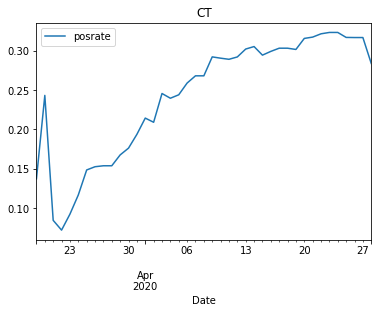

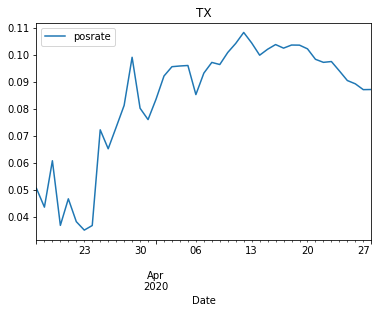

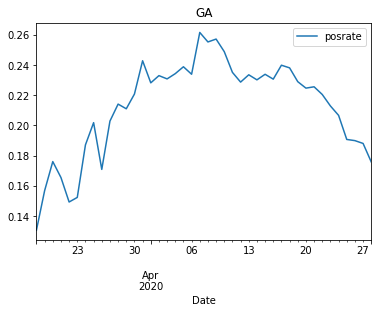

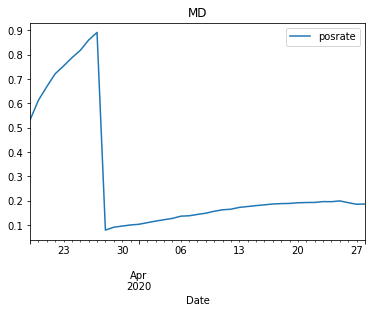

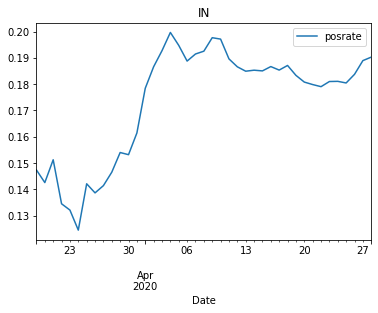

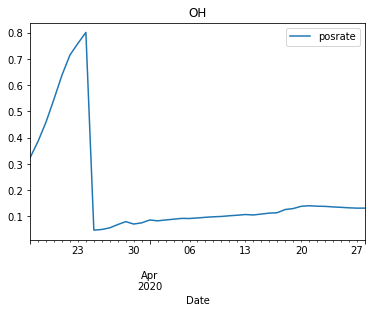

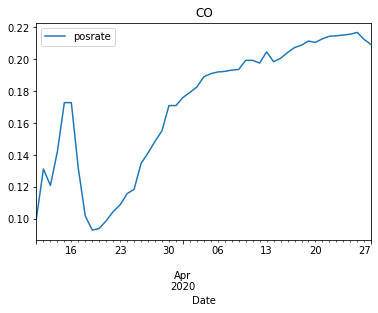

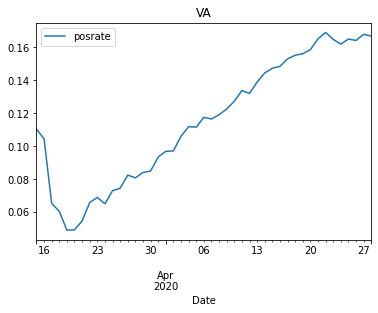

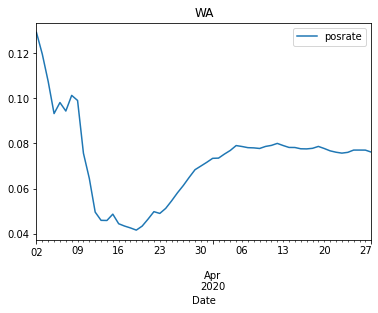

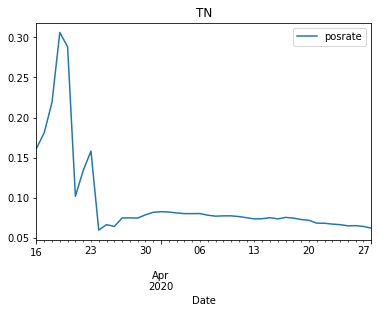

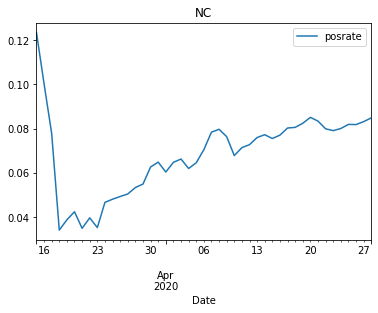

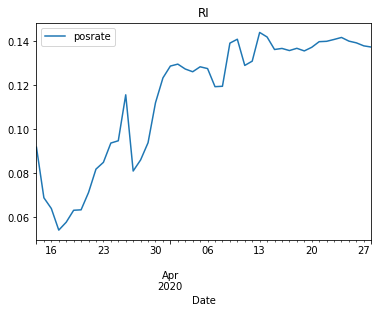

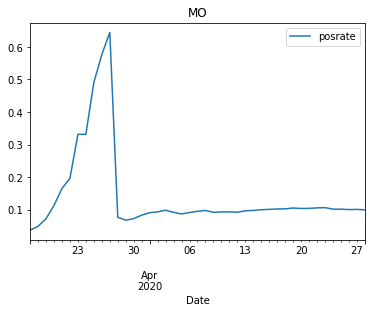

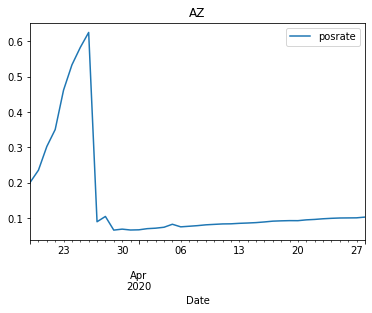

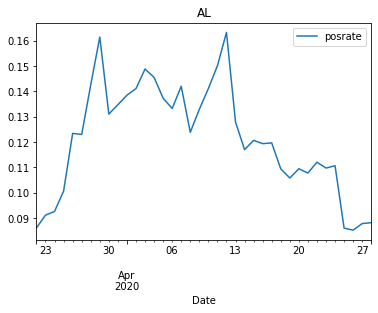

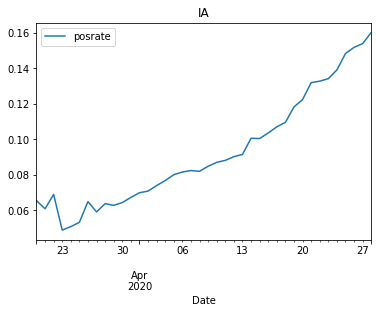

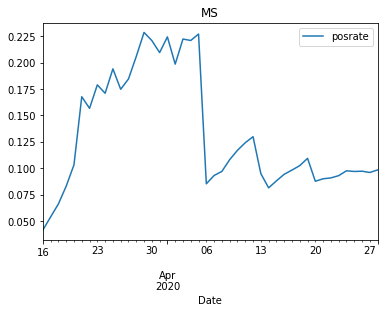

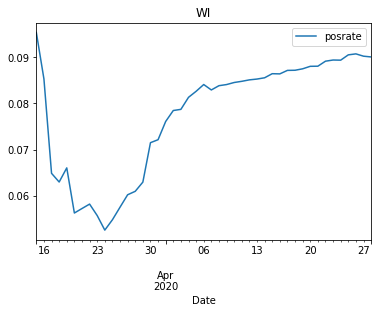

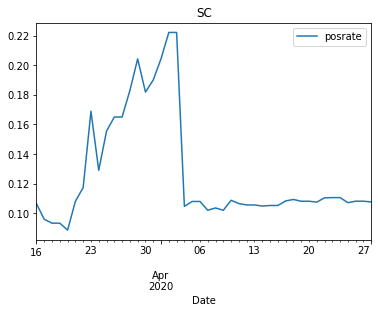

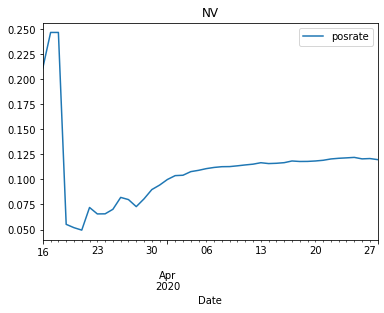

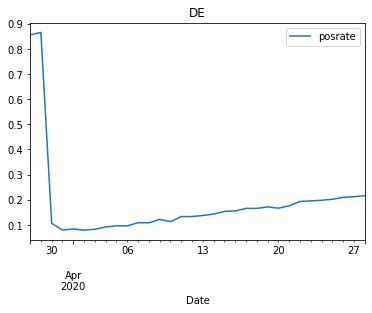

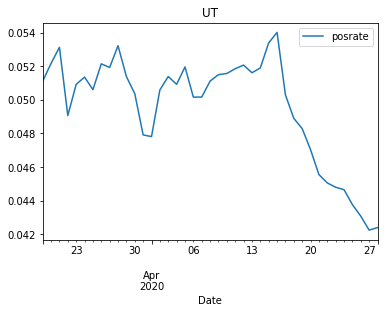

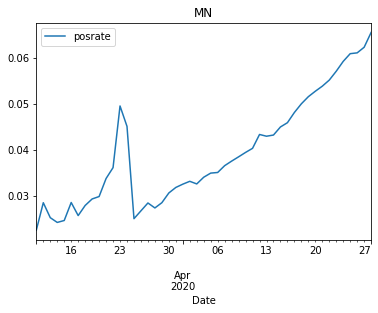

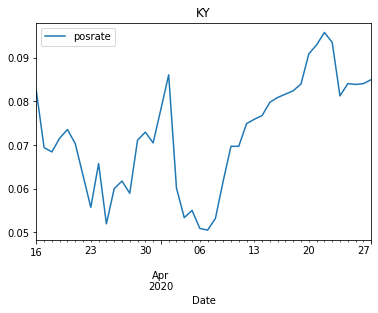

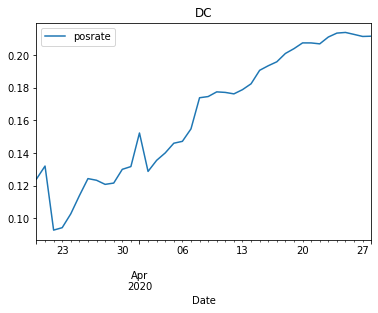

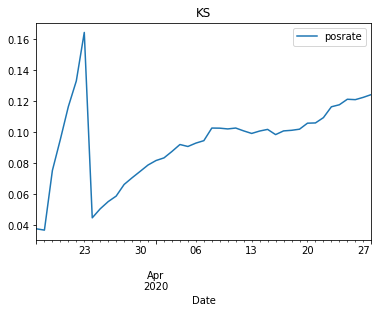

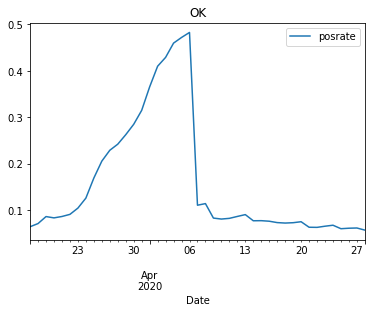

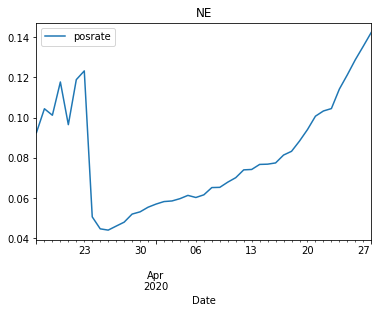

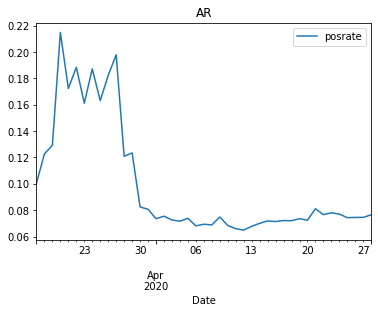

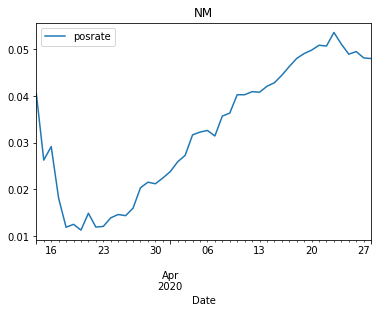

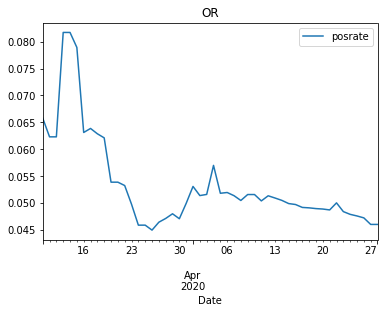

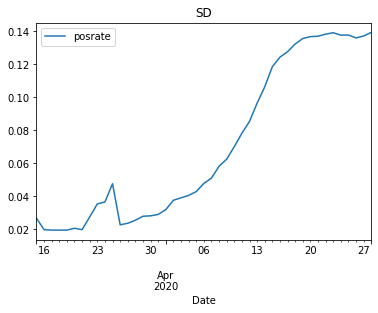

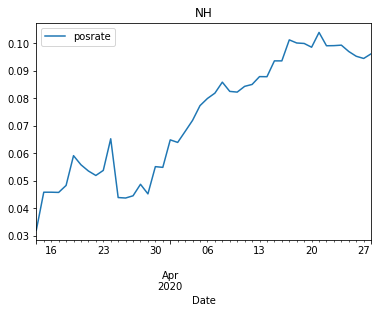

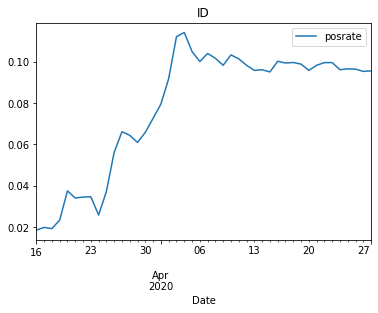

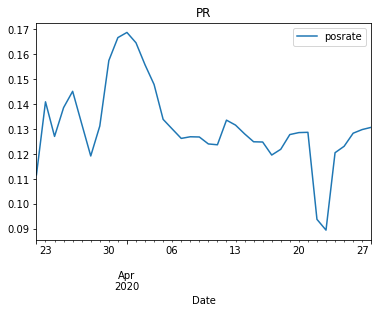

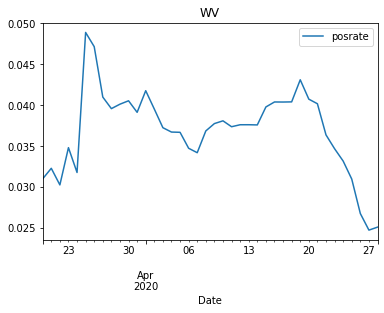

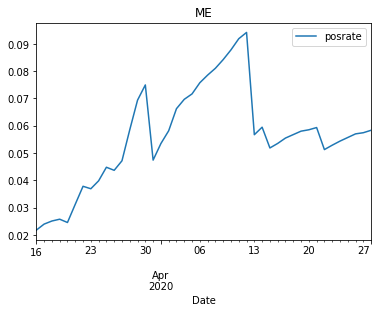

In [13]:
# Plot time series of fraction of tests that are positive (by state)
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

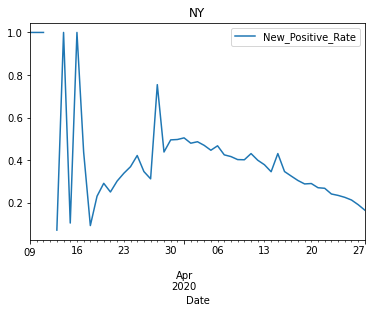

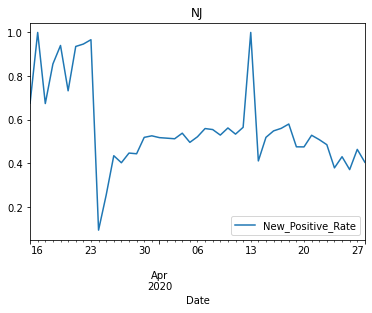

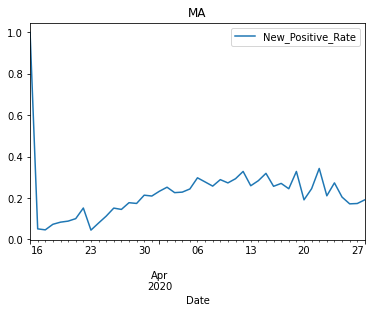

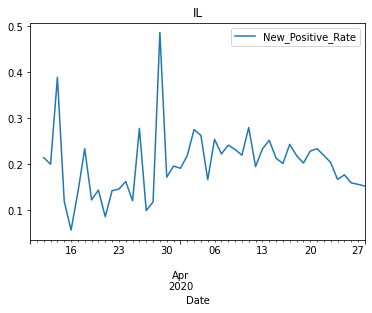

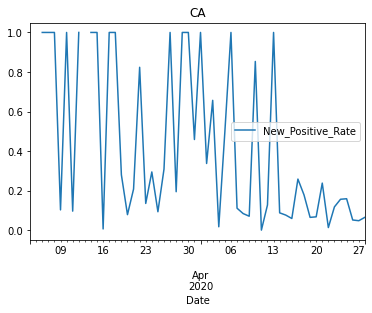

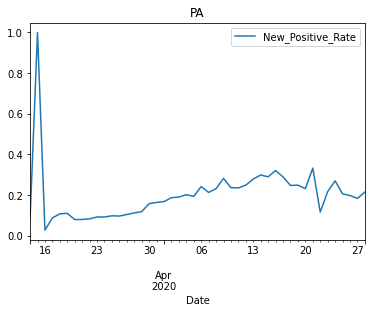

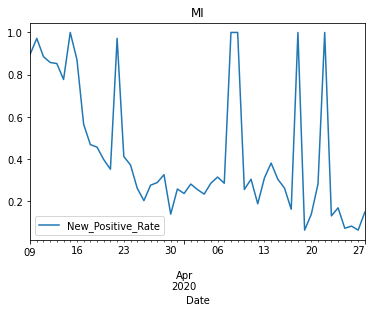

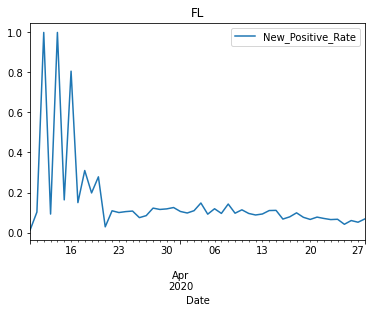

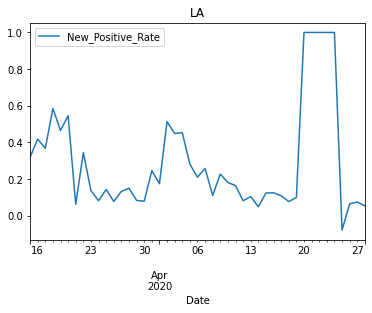

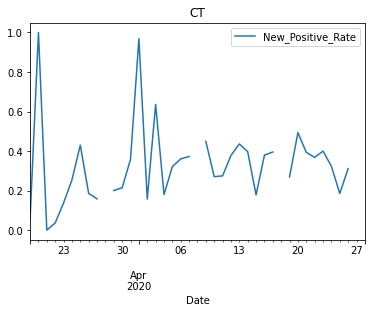

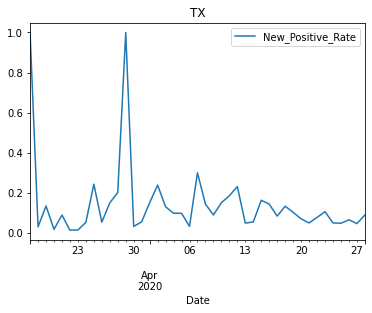

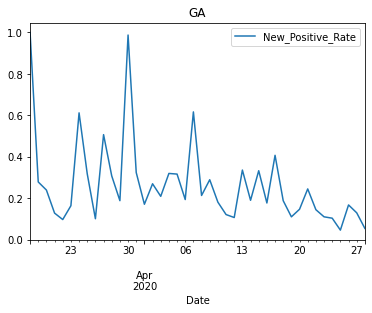

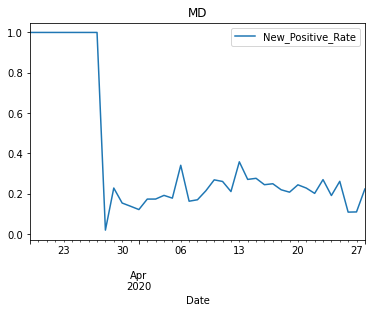

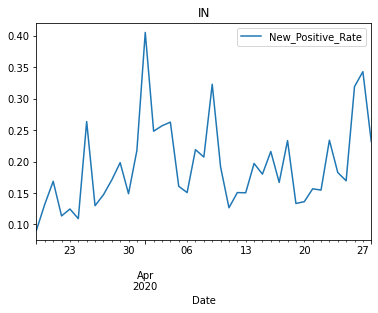

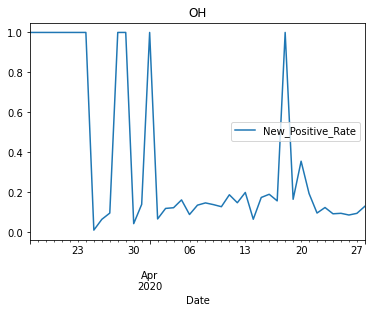

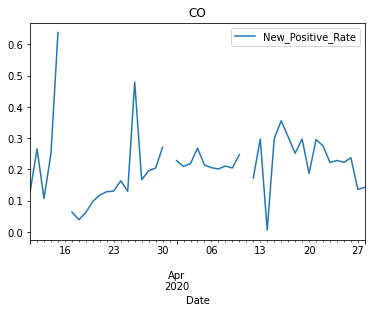

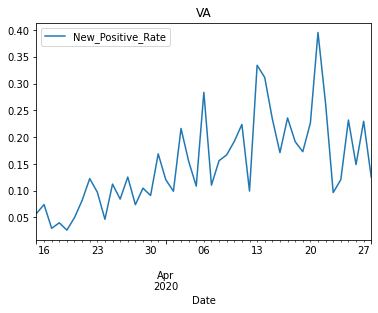

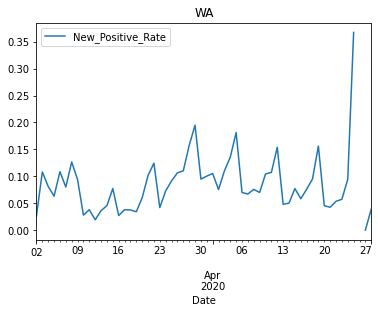

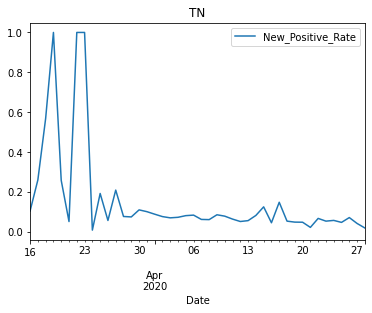

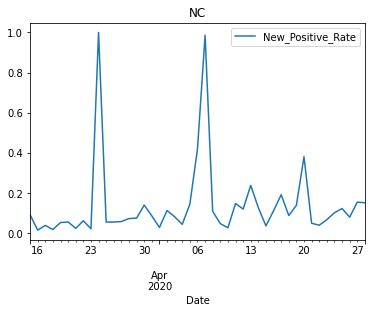

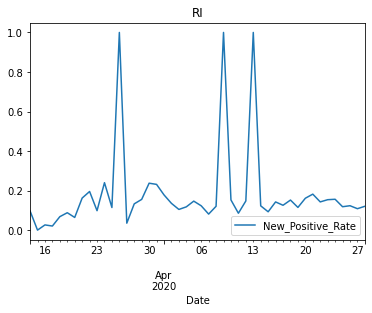

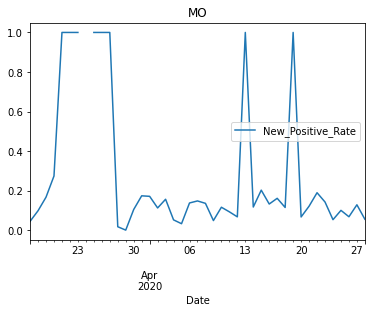

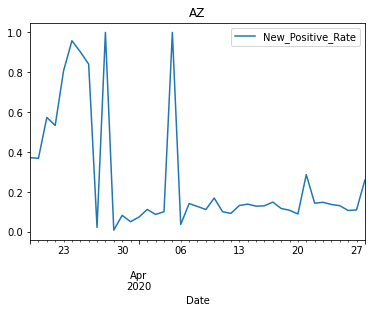

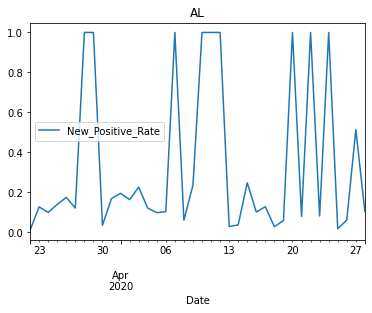

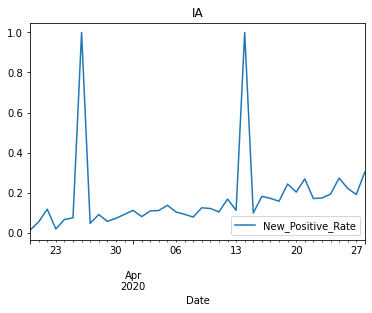

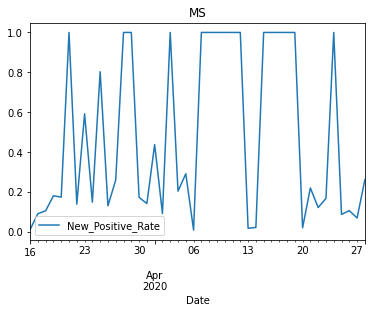

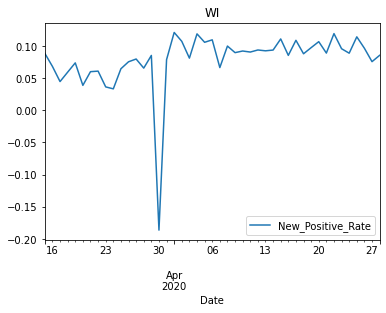

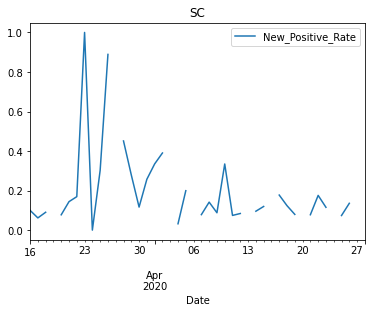

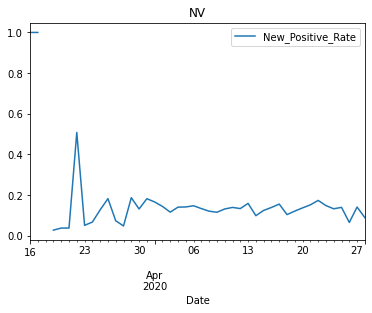

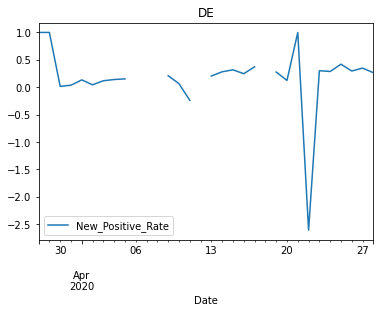

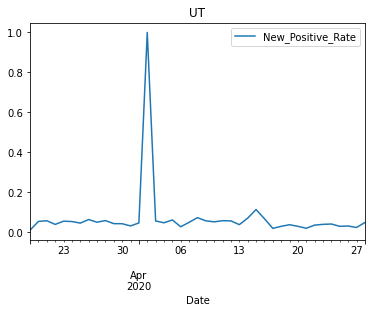

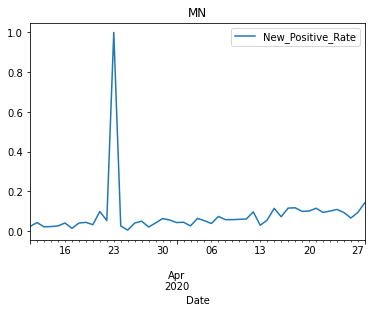

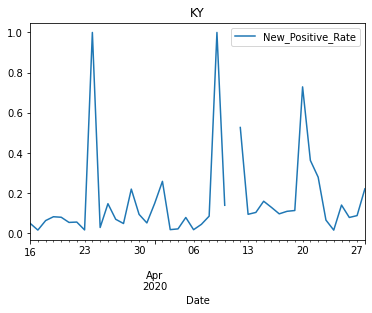

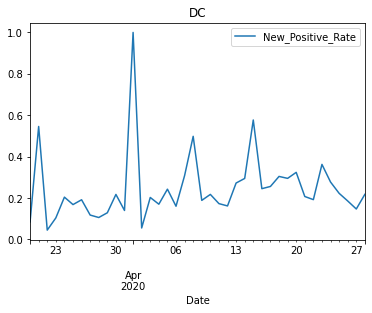

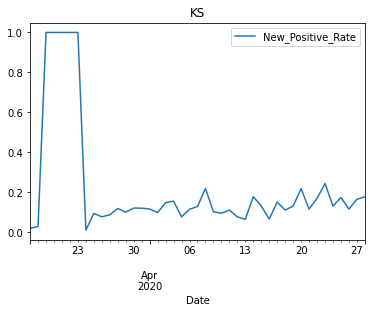

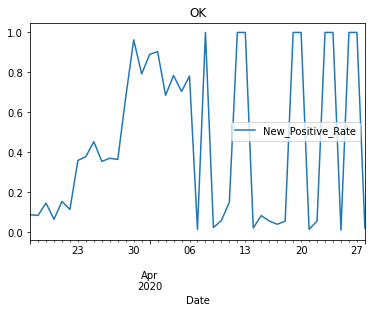

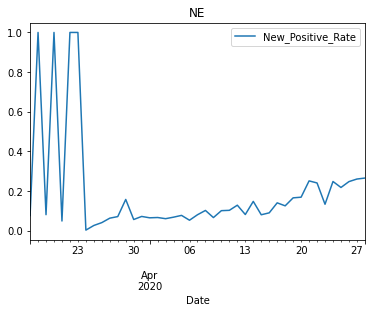

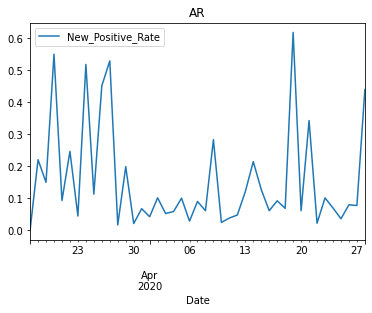

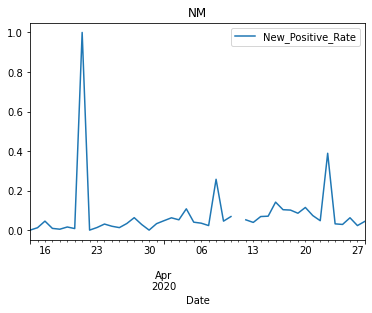

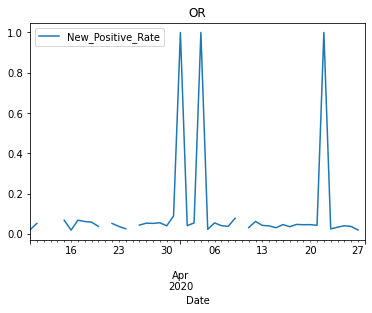

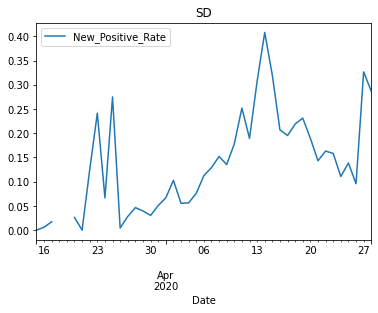

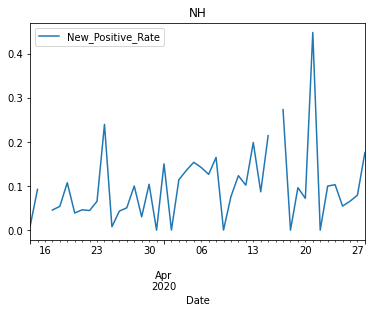

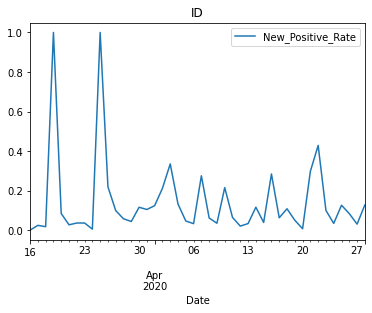

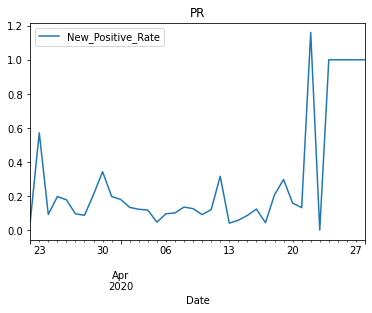

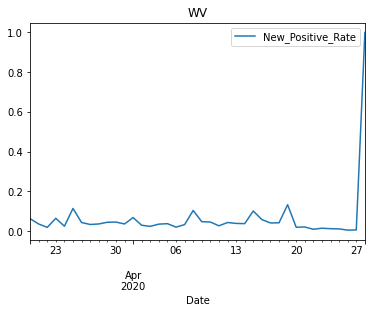

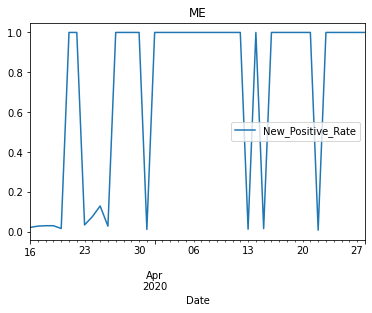

In [14]:
# Plot time series of fraction of NEW tests that are positive, by state
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  df[df.Total>200][['Date',
                    'New_Positive_Rate']].set_index('Date').plot(y='New_Positive_Rate', 
                                                                 title=state)
  plt.show()

In [15]:
# Show mean fraction of cumulative positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# It's noteworthy that most of the standard deviations are small compared to the means
#    and that the means vary quite a lot by state.
# So within-state results (for positive rate) are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
OR     0.050609  0.004257
WV     0.034836  0.009224
MN     0.041107  0.011541
KY     0.072118  0.012595
WA     0.069339  0.012723
WI     0.077017  0.012746
NM     0.032550  0.014378
NC     0.066416  0.015958
ME     0.056758  0.017683
NH     0.075447  0.020493
IN     0.174403  0.021688
TX     0.083864  0.022013
KS     0.094039  0.026019
RI     0.117303  0.027373
NE     0.081608  0.027421
PR     0.133010  0.028622
ID     0.079563  0.029252
FL     0.109441  0.029708
IL     0.180737  0.033496
DC     0.165084  0.037678
NV     0.107970  0.037906
SC     0.127033  0.038100
VA     0.115449  0.039406
CO     0.175152  0.040788
AR     0.099023  0.044261
PA     0.152266  0.046618
SD     0.072760  0.047488
MS     0.134024  0.054023
UT     0.061356  0.054196
IA     0.104485  0.054565
TN     0.093719  0.055307
CA     0.130033  0.059755
MA     0.169895  0.061852
NY     0.351544  0.068073
CT     0.245169  0.076518
LA     0.202271  0.076529
GA     0.231092  0.124150
OK     0.156135  0.132197
MO     0.140724  0.132437
MI     0.372105  0.133697
NJ     0.505224  0.136675
AZ     0.149102  0.143834
AL     0.187298  0.188281
OH     0.191396  0.202394
MD     0.290906  0.247780
DE     0.293072  0.252559

In [16]:
# Show mean fraction of DAILY positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# These are less dramatic than the previous table, but still tend to show
#    that within-state results are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df.sort_values(['State','Date']).copy()
df['New_Positives'] = df['Positive'].diff()  # Kluge because it's wrong when the state changes
df['New_Negatives'] = df['Negative'].diff()  #   but OK because we use only after 3/16
df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
df = df[df.Date>'2020-03-16'][['Date', 'New_Positive_Rate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.New_Positive_Rate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
WI     0.078991  0.047043
FL     0.105182  0.052417
WA     0.092412  0.060533
IL     0.201484  0.066717
IN     0.197269  0.069547
PA     0.189342  0.075103
MA     0.209667  0.080591
VA     0.155130  0.084487
NH     0.100720  0.086032
CO     0.204660  0.089298
SD     0.145296  0.101222
NY     0.358462  0.118885
MN     0.087395  0.146199
WV     0.063119  0.150769
NV     0.150921  0.152464
NM     0.083003  0.160695
DC     0.249764  0.164943
AR     0.154863  0.166325
NJ     0.551994  0.187700
TX     0.145344  0.202656
NC     0.142476  0.207301
ID     0.147561  0.214050
SC     0.201699  0.216637
RI     0.191934  0.228594
KY     0.170539  0.232708
GA     0.282666  0.236056
UT     0.113740  0.246216
TN     0.157680  0.250886
CT     0.359062  0.254818
OR     0.118367  0.258224
MI     0.348235  0.261052
NE     0.198700  0.268617
IA     0.232129  0.289452
KS     0.221539  0.289783
AZ     0.271229  0.295763
LA     0.288336  0.301342
PR     0.261410  0.329145
MD     0.410530  0.354623
MO     0.280819  0.356954
CA     0.354974  0.367071
OH     0.371977  0.398864
OK     0.458372  0.401586
MS     0.489410  0.421419
AL     0.407819  0.424223
ME     0.730387  0.438830
DE     0.409146  0.641564

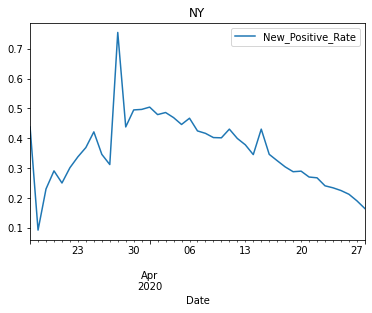

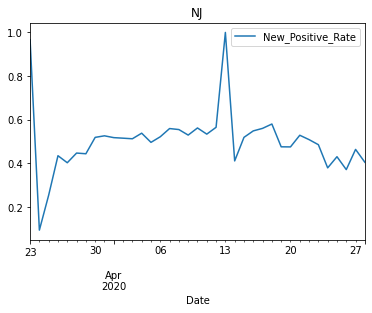

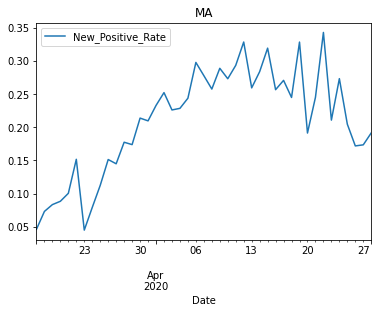

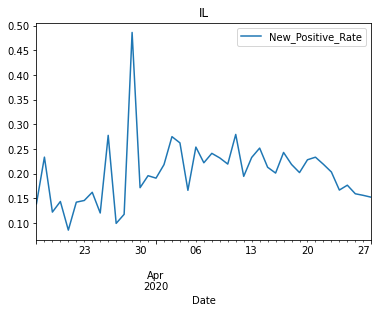

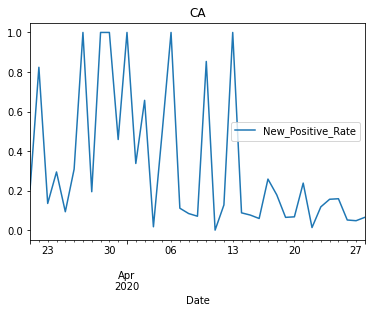

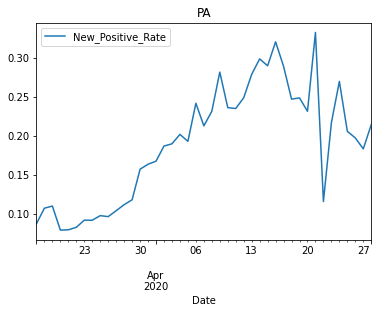

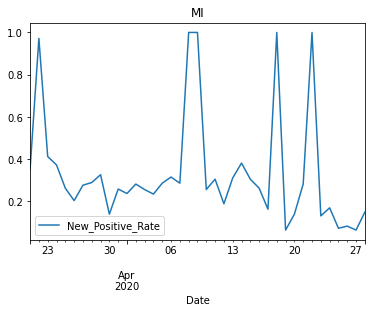

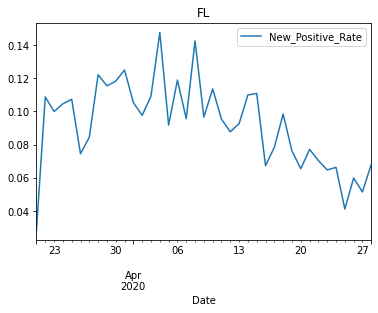

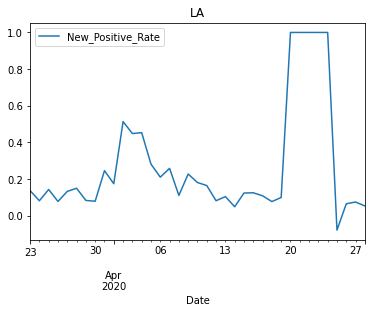

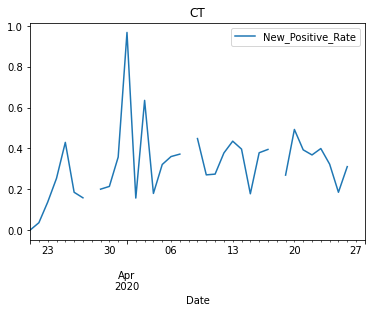

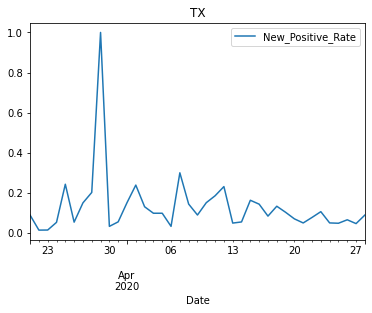

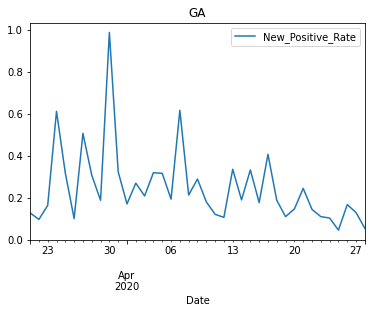

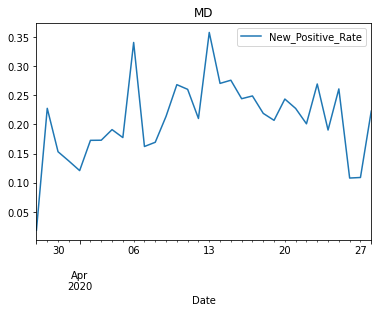

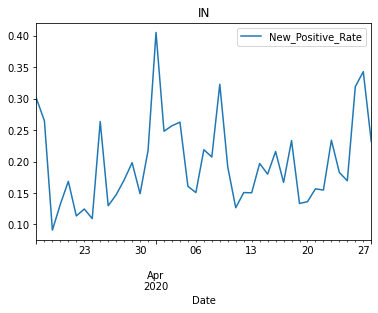

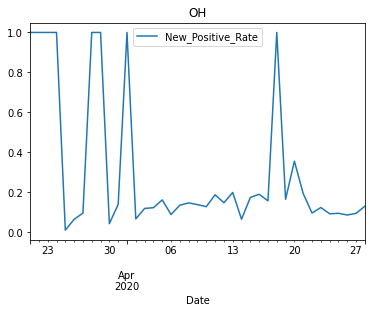

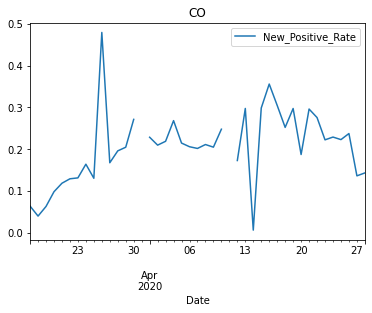

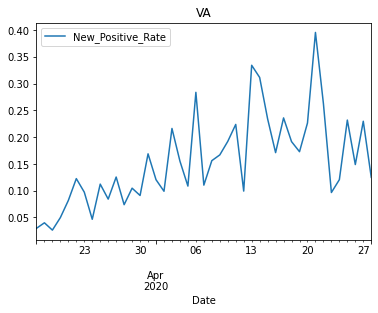

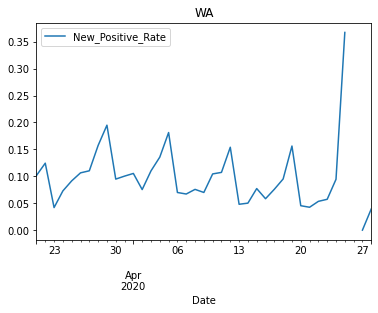

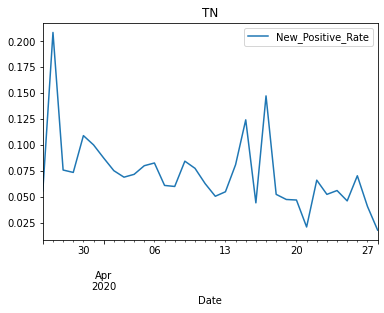

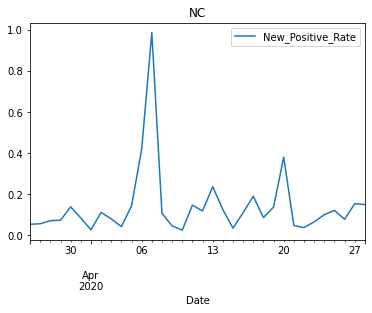

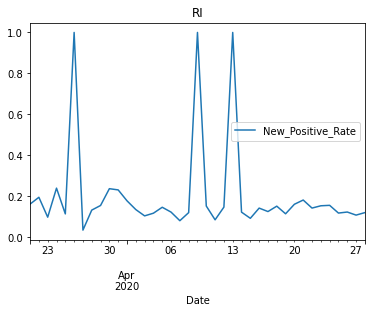

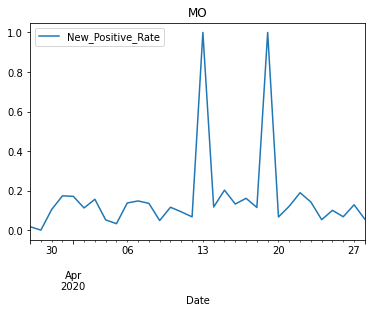

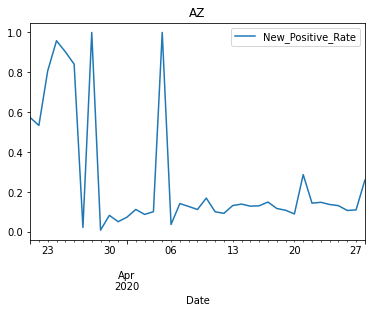

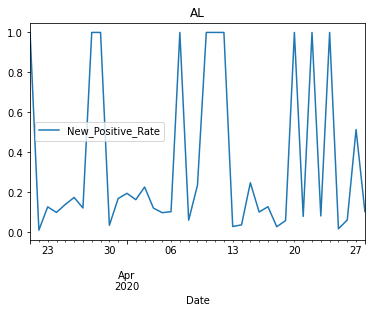

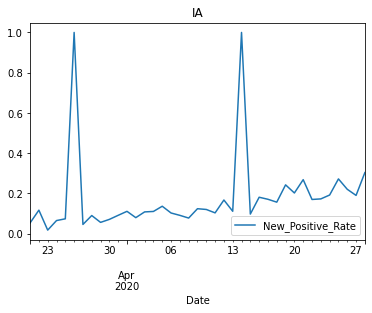

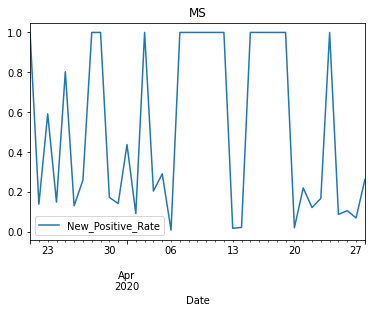

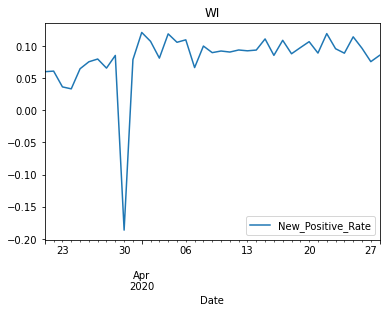

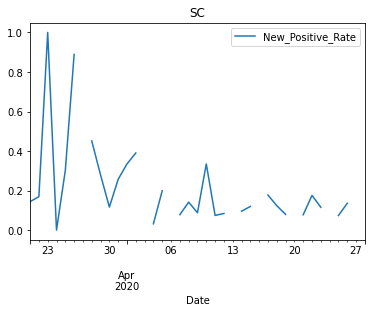

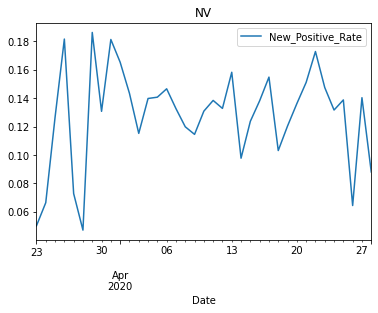

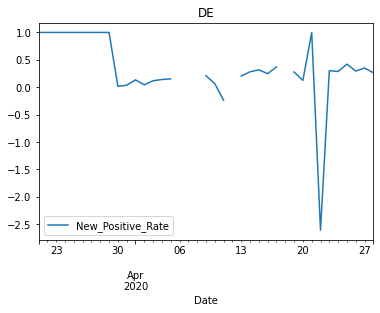

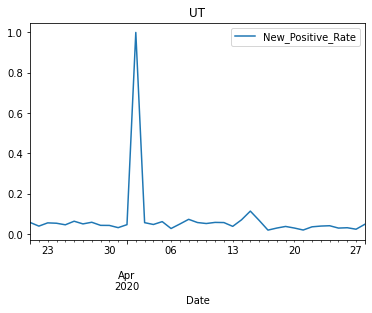

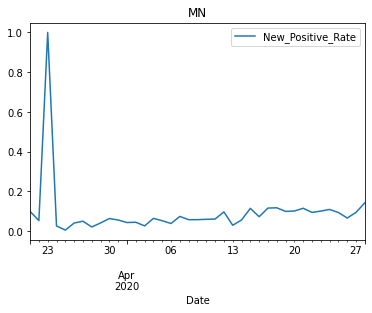

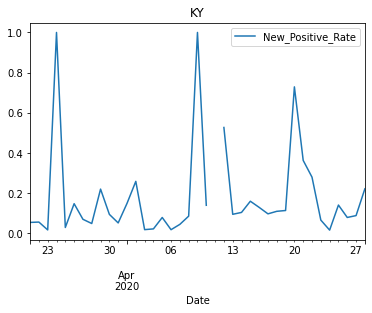

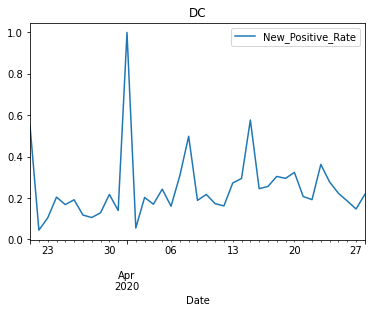

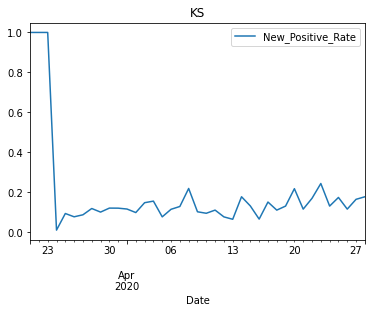

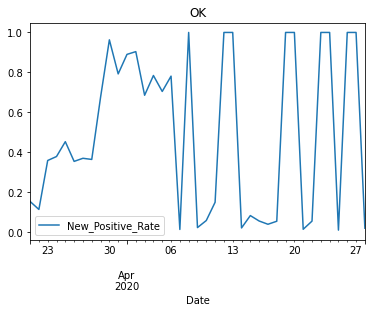

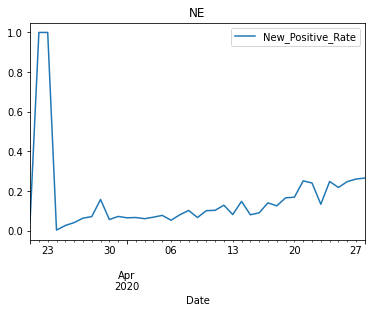

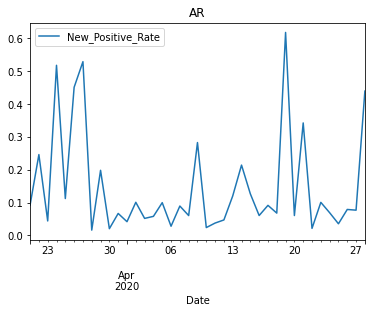

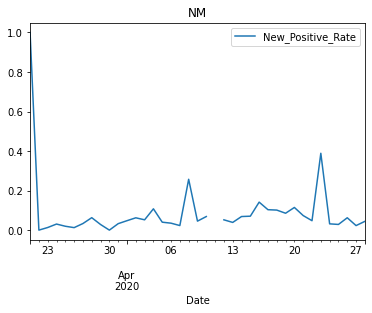

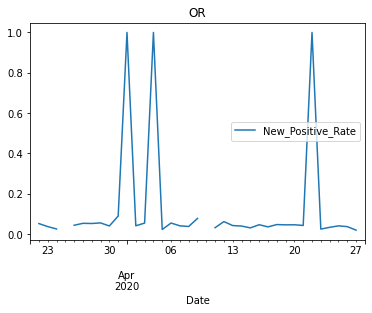

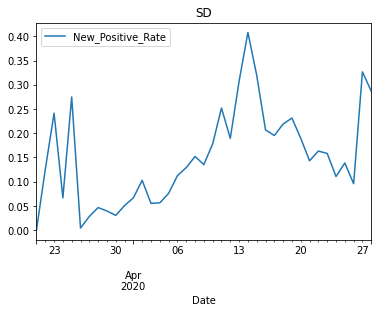

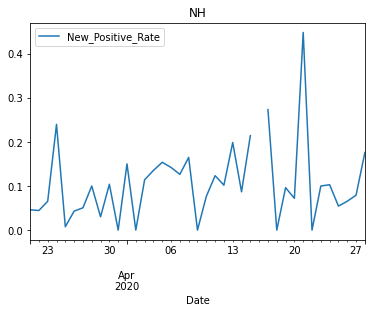

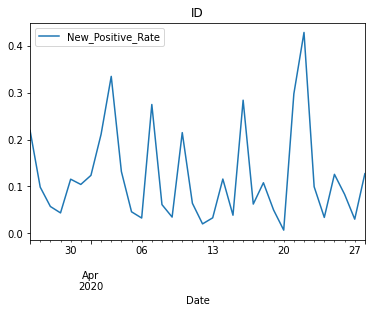

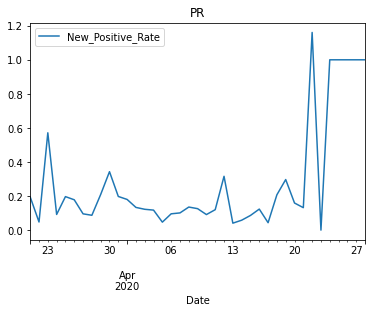

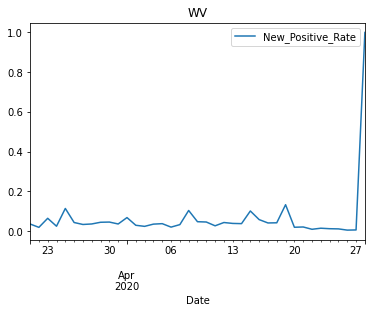

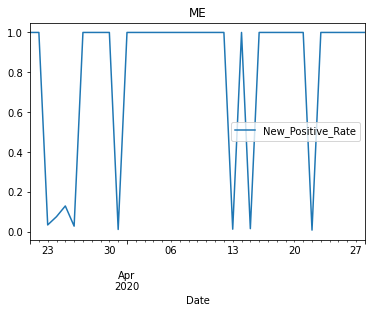

In [17]:
# Plot time series of fraction of NEW tests that are positive, by state,
#   with different start dates for different states, 
#   because positive rates stabilized at different times
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'
                             ).plot(y='New_Positive_Rate', title=state)
  plt.show()